In [2]:
import time
import json
import ast
import os
import datetime
from rich.progress import track

import io
from collections import defaultdict

import imageio
import boto3
import pandas as pd
import numpy as np
import imageio
import matplotlib.pyplot as plt
# import seaborn as sns

from brtdevkit.core.db.athena import AthenaClient
from brtdevkit.data import Dataset
from timezonefinder import TimezoneFinderL
import pytz
from rich.progress import track
from aletheia_dataset_creator.dataset_tools.aletheia_dataset_helpers import imageids_to_dataset
from aletheia_dataset_creator.config.dataset_config import LEFT_CAMERAS, ALL_CAMERA_PAIRS_LIST
%matplotlib inline
pd.set_option('display.max_rows', 500)
import json
import cv2
import os
import multiprocessing as mp    

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dl.utils.io_utils import normalize_image
import imageio
from pathlib import Path

%matplotlib inline
from cv.core.image_quality_server_side import ImageQuality

# from cv.core.image_quality_server_side_halo import ImageQuality
from dl.utils.config import DEFAULT_TONEMAP_PARAMS

In [3]:
directory = '/data2/jupiter/datasets/halo_rgb_stereo_train_v6_0/'
csv_name = 'master_annotations.csv'
def load_object(directory, row, get_label=False):
    folder_path  = directory + "/processed/images/" + row['id'] + "/"
    label_file_names = [f for f in os.listdir(folder_path) if 'stereo' not in f]
    file_names = sorted([f for f in os.listdir(folder_path) if 'stereo' in f])
    camss = [tuple(n.strip('.npz').split('_')[-2::]) for n in file_names]
    result = []
    for file_name, cams in zip(file_names, camss):
        image_npz = np.load(folder_path + file_name, allow_pickle=True)
        if get_label:
            label_file = None
            for lf in label_file_names:
                if lf.endswith(f"{cams[0]}_{cams[1]}.npz"):
                    label_file = lf
            assert label_file is not None
            label = np.load(folder_path + label_file)['left']
            result.append((image_npz, cams, label))
        else:
            result.append((image_npz, cams))
    return result


In [4]:
df = pd.read_csv(directory + csv_name)

/home/alex.li/miniconda3/envs/cvml/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (0,1,78,89,90,91,92,93,95,96,98,99,100,101,102,103,104,105,106,116,149,153,154,159,170,173,195,196,198,199,200,201,226,227,234,235,249,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,270,274,275,276,279,283) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
def fill_nan_geometries(df):
    # Old data did not have a camera_geometry so they will be NaN.
    # Set the camera geometry label even for NA data according to the sheet:
    # https://docs.google.com/spreadsheets/d/1LwssbEyW9TMCkiGMtrxvqu-B1AIB_Jv0Rg0LR4EjmyM/edit#gid=0
    robot_name_to_geom = {
        'halohitchhiker_91': 'puk30',
        'halohitchhiker_92': 'puk30',
        'halohitchhiker_151': 'puk30',
        'halohitchhiker_152': 'puk30',
        'halohitchhiker_153': 'puk30',
        'halohitchhiker_161': 'puk30',
        'halohitchhiker_162': 'puk30',
        'halohitchhiker_163': 'puk30',
        'halohitchhiker_171': 'puk30',
        'halohitchhiker_172': 'puk30',
        'halohitchhiker_173': 'puk30',
        'halohitchhiker_181': 'puk30',
        'halohitchhiker_182': 'puk30',
        'halohitchhiker_183': 'puk30',
        'halohitchhiker_191': 'puk30',
        'halohitchhiker_192': 'puk30',
        'halohitchhiker_193': 'puk30',
        'halohitchhiker_101': 'springhalo2023', 
        'halohitchhiker_102': 'springhalo2023', 
        'halohitchhiker_103': 'springhalo2023', 
        'halohitchhiker_111': 'springhalo2023', 
        'halohitchhiker_112': 'springhalo2023', 
        'halohitchhiker_113': 'springhalo2023',
        'halohitchhiker_121': 'springhalo2023',
        'halohitchhiker_122': 'springhalo2023',
        'halohitchhiker_123': 'springhalo2023',
        'halohitchhiker_201': 'peaty30',
        'halohitchhiker_202': 'peaty30',
        'halohitchhiker_211': 'peaty30',
        'halohitchhiker_212': 'peaty30',
        'halohitchhiker_221': 'peaty30',
        'halohitchhiker_222': 'peaty30',
        'halohitchhiker_81': 'peaty30',
        'halohitchhiker_82': 'peaty30',
    }
    nan_entries = df[df['camera_geometry_label'].isna()]
    df.loc[df['camera_geometry_label'].isna(), 'camera_geometry_label'] = nan_entries['robot_name'].map(robot_name_to_geom)
df = df.drop_duplicates('id')
fill_nan_geometries(df)

In [6]:
df_small =df.groupby(['camera_geometry_label', 'camera_location','camera_location_right']).sample(50,replace=True)

In [7]:
total_count = defaultdict(lambda:0)
ego_count = {}
for i, row in track(df_small.iterrows(), total=len(df_small)):
    if row['camera_location'][0] == 'I':
        continue # Not doing implement cameras
    try:
        objs = load_object(directory, row, get_label=True)
    except Exception as e:
        print(f"Exception on {i}: {str(e)}")
        continue
    ego_ids = []
    for k, v in json.loads(row['label_map']).items():
        if v[:3] == 'Ego':
            ego_ids.append(int(k))
    for obj, cam_pair, label in objs:
        ego_key = (row['camera_geometry_label'], cam_pair[0], cam_pair[1])
        total_count[ego_key] += 1
        for id in ego_ids:
            label_is_ego = (label == id).astype(np.int32)
            if ego_key not in ego_count:
                ego_count[ego_key] = label_is_ego
            else:
                ego_count[ego_key] += label_is_ego
for ego_key in ego_count.keys():
    ego_count[ego_key] = ego_count[ego_key].astype(np.float32) / total_count[ego_key]

Output()

{'1': 'Tilled field',
 '2': 'Untilled field',
 '3': 'Road',
 '4': 'Roadside Buffer',
 '5': 'Utility pole',
 '6': 'Trees',
 '7': 'Sky',
 '8': 'Immovable Objects',
 '9': 'Buildings',
 '10': 'Tractors or Vehicles',
 '11': 'Humans',
 '12': 'Animals',
 '13': 'Ignore',
 '14': 'implement',
 '15': 'sweep',
 '16': 'harrow_tine',
 '17': 'basket',
 '18': 'basket_marker',
 '19': 'Ego Tractor',
 '20': 'Implement_hitch',
 '21': 'Light Artifacts',
 '22': 'Heavy Dust',
 '23': 'Birds',
 '24': 'Tall Weeds',
 '25': 'Airborne Debris',
 '26': 'Cotton Debris',
 '27': 'Object Lights',
 '28': 'Flooded Area',
 '29': 'Ego Reflective Surface',
 '30': 'Ego Mirror Housing'}

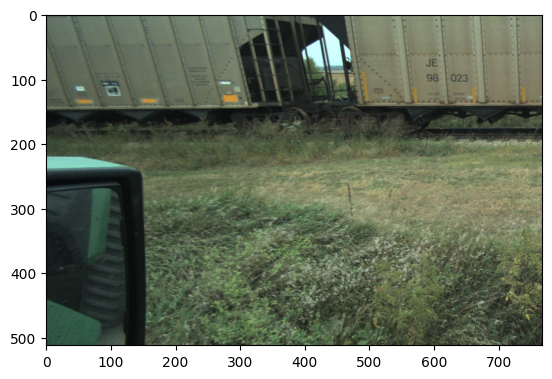

In [8]:
df_1 = df[(df['camera_geometry_label'] == 'puk30') & (df['camera_location'] == 'T06') &  (df['camera_location_right'] == 'T08')]
obj = load_object(directory, df_1.iloc[6], get_label=True)[1]
plt.imshow(normalize_image(obj[0]['left'], hdr_mode=True))
import json
json.loads(df_1.iloc[0]['label_map'])

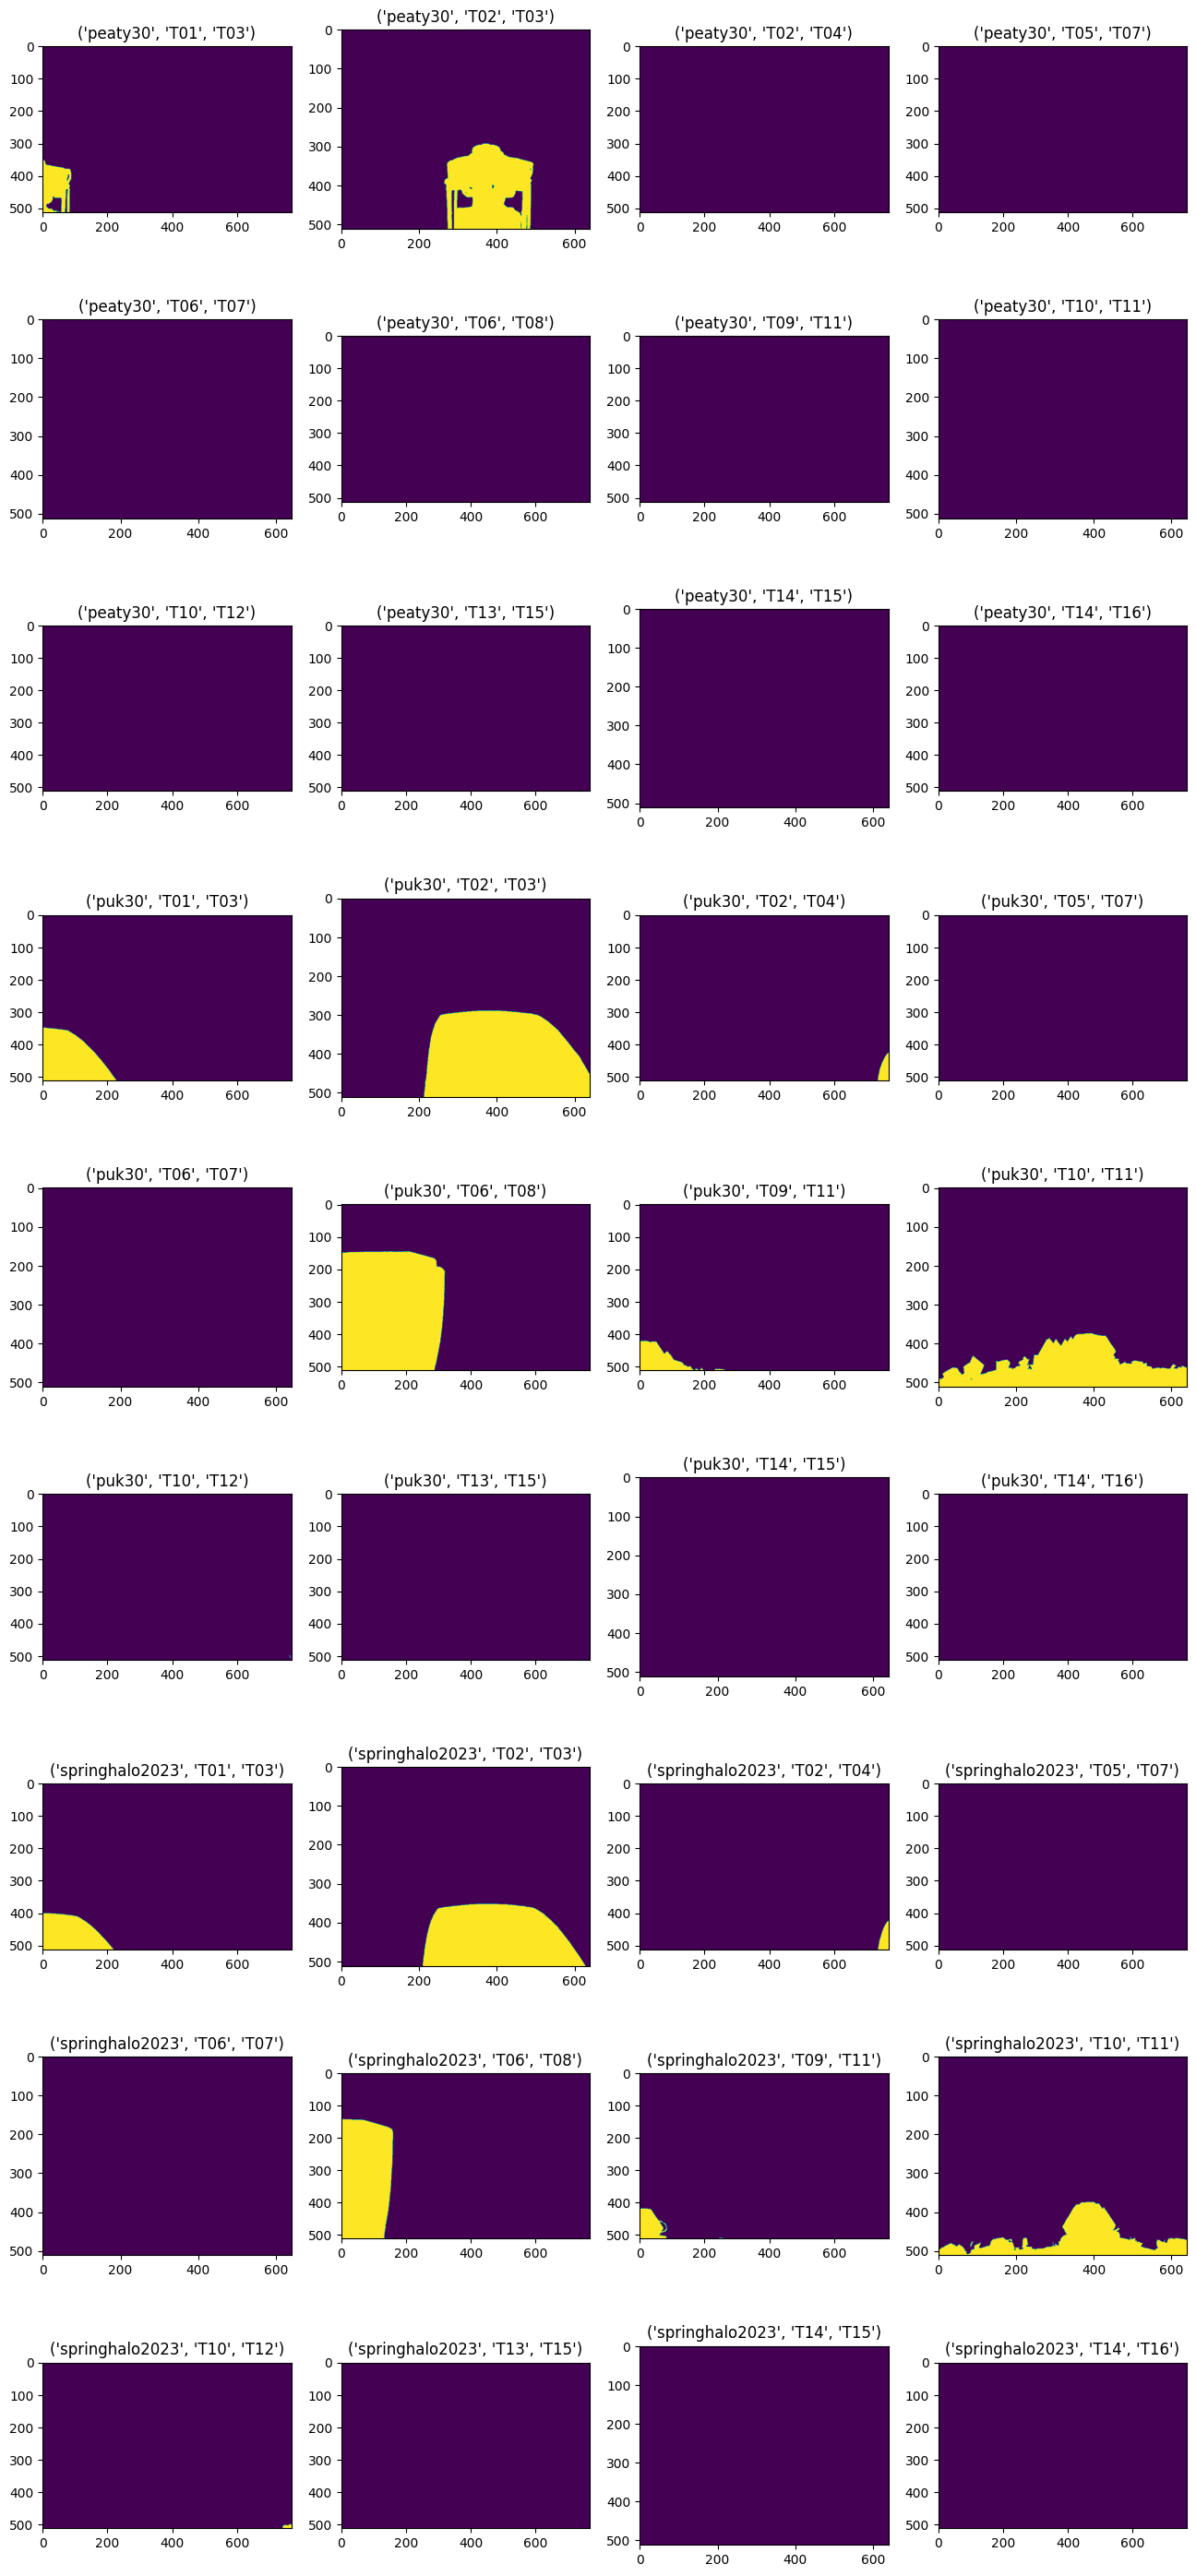

In [ ]:
def plot_several_images(img_list, titles):
    cols = 4
    rows = (len(img_list) + 3) // cols
    fig, ax = plt.subplots(rows, cols, squeeze=False, figsize = (16, rows * 4))
    for i, img in enumerate(img_list):
        ax[i // cols][i % cols].imshow(img)
        ax[i // cols][i % cols].set_title(titles[i])
plot_several_images(ego_count.values(), list(ego_count.keys()))

In [141]:
save_path = Path('/home/alex.li/git/JupiterCVML/europa/base/src/europa/dl/config/halo_masks')
for (geom_label, cam_1, cam_2), v in ego_count.items():
    image_dir = save_path / geom_label
    os.makedirs(image_dir, exist_ok=True)
    image_path = image_dir / f"{cam_1}_{cam_2}_mask.png"
    image = np.uint8(v > .05) * 255
    imageio.imsave(image_path, image)